# Лабораторна робота №1. Дослiдження бiблiотек та фреймворкiв для комп’ютерної обробки зображень


**Виконала** студентка групи КІ-41мп Додонова Марія

**Мета:** Ознайомлення з програмними iнструментами (бiблiотеками, фреймворками) для обробки зображень, дослiдження i реалiзацiя операцiї згортки, навчитись виконувати попередню обробку зображень (застосування фiльтрiв,нормалiзацiя).

## Порядок виконання

1. Реалiзувати операцiю згортки для матрицi з нуля за допомогою NumPy.

2. Обрати будь-яке кольорове зображення. Зчитати його за допомогою бiблiотеки cv2 командою cv2.imread. Пам’ятайте, що колiрний простiр, у якому cv2.imread вiддає зображення, це BGR.

3. Для подальшої роботи використовуйте фреймворк TensorFlow або PyTorch.

4. Застосувати до зображення власний фiльтр Гауса, box-фiльтр, unsharp masking. Вiзуалiзувати результати. Зауважте, що для коректного застосування даних фiльтрiв до кольорового зображення необхiдно використовувати згортку по каналам (окремо для R, G та B у випадку кольорового простору RGB).

5. По бажанню: виконати видiлення границь на зображеннi за допомогою оператору Собеля.

6. Дослiдити варiанти нормалiзацiї зображення. Виконати min-max нормалiзацiю зображення, стандартизацiю зображення (image standardization).

## Виконання роботи

### 1. Реалiзувати операцiю згортки для матрицi з нуля за допомогою NumPy.

In [1]:
import numpy as np

In [2]:
def convolve(matrix, kernel, stride=(1, 1), padding=(0, 0)):
  # Get heights and widths of matrix, kernel, stride and padding
  matrix_h, matrix_w = matrix.shape
  kernel_h, kernel_w = kernel.shape
  stride_y, stride_x = stride
  pad_h, pad_w = padding

  # Add padding to the matrix
  padded_matrix = np.pad(matrix, ((pad_h, pad_h), (pad_w, pad_w)), mode="constant")

  # Calculate size of output
  output_h = (matrix_h + 2*pad_h - kernel_h)//stride_y + 1
  output_w = (matrix_w + 2*pad_w - kernel_w)//stride_x + 1

  output = np.zeros((output_h, output_w))

  for i in range(output_h):
    for j in range(output_w):
      # Calculate indexes of current region in padded matrix
      i0, j0 = i*stride_y, j*stride_x
      i1, j1 = i0 + kernel_h, j0 + kernel_w

      # Calculate and save output elment
      region = padded_matrix[i0:i1, j0:j1]
      output[i, j] = (region * kernel).sum()

  return output

In [3]:
matrix = np.array([[45, 63, 27, 90, 34],
                   [36, 18, 81, 9, 87],
                   [9, 54, 72, 99, 56],
                   [83, 23, 12, 43, 54],
                   [27, 8, 19, 67, 69]])

kernel = np.ones((3, 3)) / 9

print(convolve(matrix, kernel))

[[45.         57.         61.66666667]
 [43.11111111 45.66666667 57.        ]
 [34.11111111 44.11111111 54.55555556]]


### 2. Обрати будь-яке кольорове зображення. Зчитати його за допомогою бiблiотеки cv2 командою cv2.imread.
Пам’ятайте, що колiрний простiр, у якому cv2.imread вiддає зображення, це BGR.

In [4]:
import matplotlib.pyplot as plt
import cv2

def imshow(image, title=None):
  plt.imshow(image)
  if title:
    plt.title(title)
  plt.axis("off")
  plt.show()

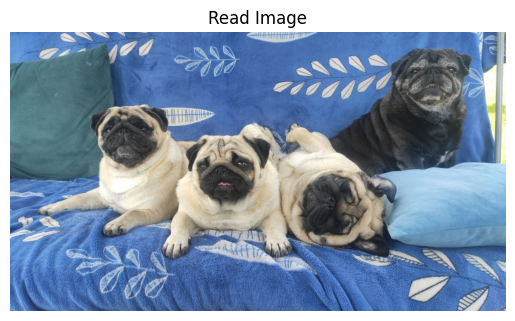

In [5]:
# Read the image (in BGR format)
image_np = cv2.imread("..\\data\\lab1\\pugs.jpg")

# Convert the image to RGB
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Show the image
imshow(image_np, "Read Image")

### 3. Для подальшої роботи використовуйте фреймворк TensorFlow або PyTorch.

Реалiзуйте наступнi пункти саме за допомогою фреймворку, не використовуйте NumPy.

In [6]:
import torch

In [7]:
# Convert the image to torch tensor with float32 data type
image_torch = torch.from_numpy(image_np).float()

# Change the shape and add the batch dimension
image_torch = image_torch.permute(2, 0, 1).unsqueeze(0)

### 4. Застосувати до зображення власний фiльтр Гауса, box-фiльтр, unsharp masking. Вiзуалiзувати результати.
Зауважте, що для коректного застосування даних фiльтрiв до кольорового зображення необхiдно використовувати згортку по каналам (окремо для R, G та B у випадку кольорового простору RGB).

In [8]:
from torch.nn.functional import conv2d

In [9]:
# Define Gaussian filter
sigma = 1.5
gaussian = torch.tensor([[2, 1, 2],
                         [1, 0, 1],
                         [2, 1, 2]], dtype=torch.float32) # x**2 + y**2
gaussian = torch.exp(-gaussian/(2*sigma**2)) / (2*torch.pi*sigma**2)
gaussian = gaussian.view(1, 1, 3, 3)

# Define box filter
box = torch.ones((1, 1, 3, 3)) / 9

# Define unsharp masking filter
unsharp = torch.tensor([[0, -1, 0],
                        [-1, 5, -1],
                        [0, -1, 0]], dtype=torch.float32)
unsharp = unsharp.view(1, 1, 3, 3)

filters = {
    "Gaussian filter": gaussian,
    "Box filter": box,
    "Unsharp masking": unsharp
}

In [10]:
# Split the image into 3 channels
channels = [image_torch[0, i, :, :].unsqueeze(0).unsqueeze(0) for i in range(3)]

In [11]:
results = {}

for name in filters:
  # Apply filter to each channel of the image
  filtered_channels = [conv2d(c, filters[name], padding=1) for c in channels]

  # Concatenate all channels
  results[name] = torch.cat(filtered_channels, dim=1)

In [12]:
for filter in results:
  # Remove the batch dimension and change the shape
  image = results[filter].squeeze(0).permute(1, 2, 0)

  # Convert to NumPy array and set datatype to uint8
  results[filter] = image.numpy().clip(0, 255).astype("uint8")

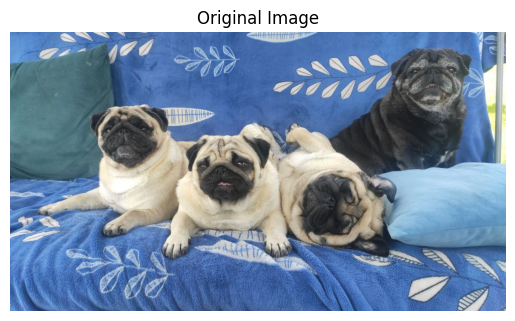

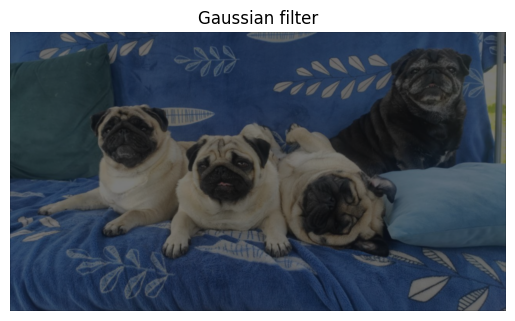

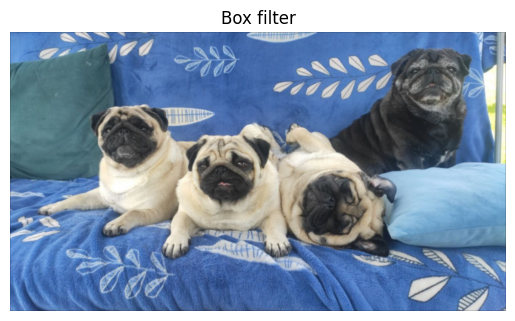

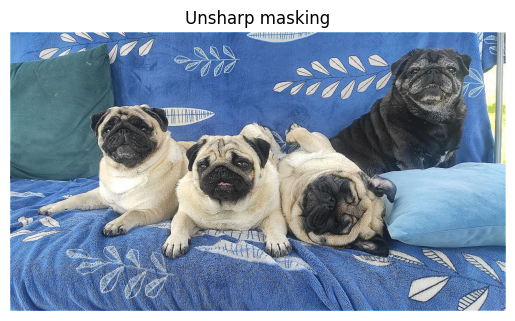

In [13]:
imshow(image_np, "Original Image")

# Visualize results
for filter in results:
  imshow(results[filter], filter)

### 5. По бажанню: виконати видiлення границь на зображеннi за допомогою оператору Собеля.

In [14]:
# Define Sobel X filter
sobel_x = torch.tensor([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]], dtype=torch.float32)
sobel_x = sobel_x.view(1, 1, 3, 3)

# Define Sobel Y filter
sobel_y = torch.tensor([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=torch.float32)
sobel_y = sobel_y.view(1, 1, 3, 3)

In [15]:
filtered_channels_x, filtered_channels_y, grad_magn_channels = [], [], []
for channel in channels:
  filtered_channels_x.append(conv2d(channel, sobel_x, padding=1))
  filtered_channels_y.append(conv2d(channel, sobel_y, padding=1))
  grad_magn_channels.append(torch.sqrt(filtered_channels_x[-1]**2 + filtered_channels_y[-1]**2))

# Concatenate all channels
results = {}
results["Sobel X filter"] = torch.cat(filtered_channels_x, dim=1)
results["Sobel Y filter"] = torch.cat(filtered_channels_y, dim=1)
results["Gradient Magnitude"] = torch.cat(grad_magn_channels, dim=1)

In [16]:
for filter in results:
  # Remove the batch dimension and change the shape
  image = results[filter].squeeze(0).permute(1, 2, 0)

  # Convert to NumPy array and set datatype to uint8
  results[filter] = image.numpy().clip(0, 255).astype("uint8")

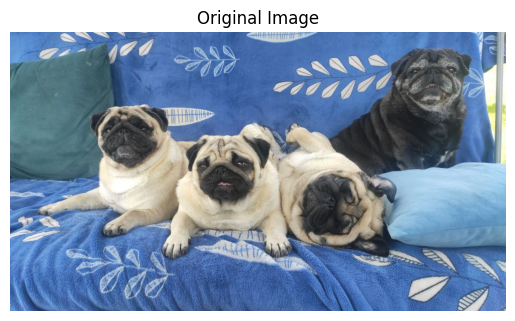

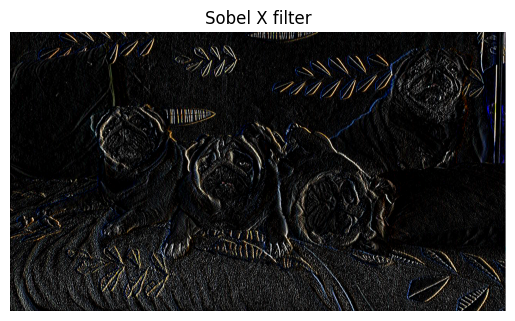

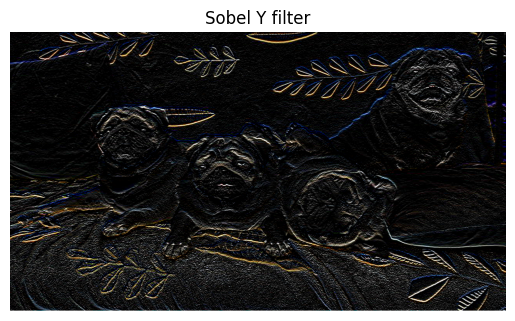

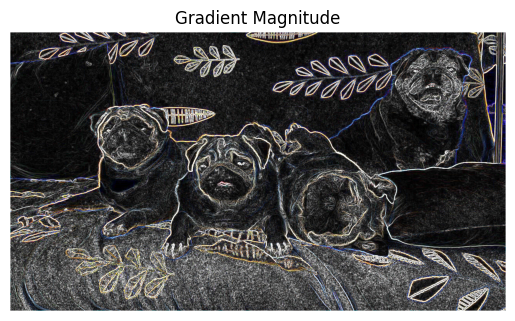

In [17]:
# Visualize results
imshow(image_np, "Original Image")

for filter in results:
  imshow(results[filter], filter)

### 6. Дослiдити варiанти нормалiзацiї зображення. Виконати min-max нормалiзацiю зображення, стандартизацiю зображення (image standardization).

In [18]:
# Min-max normalization
min_v, max_v = image_torch.min(), image_torch.max()
normalized_image = (image_torch - min_v) / (max_v - min_v)

print(f"Before Min-Max Normalization:\n{image_torch}\n")
print(f"After Min-Max Normalization:\n{normalized_image}")

Before Min-Max Normalization:
tensor([[[[ 91.,  85.,  83.,  ..., 163., 154., 145.],
          [ 90.,  84.,  83.,  ..., 158., 149., 139.],
          [ 89.,  85.,  85.,  ..., 150., 141., 132.],
          ...,
          [ 90., 111.,  78.,  ..., 191., 198., 195.],
          [ 81., 100.,  95.,  ..., 186., 196., 196.],
          [ 87.,  91., 101.,  ..., 170., 190., 201.]],

         [[138., 132., 130.,  ..., 169., 163., 154.],
          [137., 131., 130.,  ..., 164., 158., 148.],
          [136., 132., 132.,  ..., 156., 150., 141.],
          ...,
          [136., 157., 124.,  ..., 199., 206., 204.],
          [127., 146., 141.,  ..., 193., 203., 203.],
          [133., 137., 147.,  ..., 177., 194., 206.]],

         [[206., 200., 198.,  ..., 167., 158., 149.],
          [205., 199., 198.,  ..., 162., 153., 143.],
          [204., 200., 200.,  ..., 154., 145., 136.],
          ...,
          [196., 217., 184.,  ..., 212., 217., 213.],
          [187., 206., 201.,  ..., 203., 211., 211.],
   

In [19]:
# Image standardization
mean = image_torch.mean()
std = image_torch.std()

standardized_image = (image_torch - mean) / std

print(f"Before Standardization:\n{image_torch}\n")
print(f"After Standardization:\n{standardized_image}")

Before Standardization:
tensor([[[[ 91.,  85.,  83.,  ..., 163., 154., 145.],
          [ 90.,  84.,  83.,  ..., 158., 149., 139.],
          [ 89.,  85.,  85.,  ..., 150., 141., 132.],
          ...,
          [ 90., 111.,  78.,  ..., 191., 198., 195.],
          [ 81., 100.,  95.,  ..., 186., 196., 196.],
          [ 87.,  91., 101.,  ..., 170., 190., 201.]],

         [[138., 132., 130.,  ..., 169., 163., 154.],
          [137., 131., 130.,  ..., 164., 158., 148.],
          [136., 132., 132.,  ..., 156., 150., 141.],
          ...,
          [136., 157., 124.,  ..., 199., 206., 204.],
          [127., 146., 141.,  ..., 193., 203., 203.],
          [133., 137., 147.,  ..., 177., 194., 206.]],

         [[206., 200., 198.,  ..., 167., 158., 149.],
          [205., 199., 198.,  ..., 162., 153., 143.],
          [204., 200., 200.,  ..., 154., 145., 136.],
          ...,
          [196., 217., 184.,  ..., 212., 217., 213.],
          [187., 206., 201.,  ..., 203., 211., 211.],
         

## Висновок

В ході виконання роботи було розроблено функцію для виконання згортки матриці, створено та застосовано до зображення власні фільтр Гаусса, box-фільтр та unsharp masking. Також було видiлено границі на зображеннi за допомогою оператору Собеля та виконано нормалізацію та стандартизацію зображення.